In [19]:
import os, sys
import pyxdf as xdf
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from mne.viz import plot_epochs_image

import joblib # to deal with deprecated function in SKlearn that is bound to autoreject
from autoreject import AutoReject

from itertools import compress


%matplotlib notebook
%matplotlib inline


path = "C:\\Users\\USUARIO\\Documents\\Pompeu Fabra\\Analyzing EEG\\EEG_recordings\\"

In [2]:
# path = "C:\\Recordings\\CurrentStudy\\exp3\\"
# xdf.load_xdf(path + "YoshesTrain1.xdf")


xdf.load_xdf(path + "ControlGroup\\YaoTrain1.xdf") 

([{'info': defaultdict(list,
               {'name': ['LSLOutletStreamName-Quality'],
                'type': ['Quality'],
                'channel_count': ['32'],
                'nominal_srate': ['1'],
                'channel_format': ['float32'],
                'source_id': ['ENOBIO-32-NE-Wifi(00:07:80:0D:71:B5) Quality'],
                'version': ['1'],
                'created_at': ['10995.07977457'],
                'uid': ['33a81537-88fb-45e0-910c-dffccbb99663'],
                'session_id': ['default'],
                'hostname': ['DESKTOP-VCGA8D3'],
                'v4address': [None],
                'v4data_port': ['16575'],
                'v4service_port': ['16578'],
                'v6address': [None],
                'v6data_port': ['16575'],
                'v6service_port': ['16578'],
                'desc': [defaultdict(list,
                             {'manufacturer': ['NeuroElectrics'],
                              'channel': [defaultdict(list,
            

In [3]:
streams = xdf.load_xdf(path + "ControlGroup\\YaoTrain1.xdf")
for i in range(len(streams[0])):
    print(i, streams[0][i]['info']['name'][0], streams[0][i]['info']['hostname'][0])
    print("")
    print(np.array(streams[0][i]['time_series']).shape)
    print("")
    print("--------------------------------------")

0 LSLOutletStreamName-Quality DESKTOP-VCGA8D3

(619, 32)

--------------------------------------
1 LSLOutletStreamName-Markers DESKTOP-VCGA8D3

(1, 0)

--------------------------------------
2 LSLOutletStreamName-EEG DESKTOP-VCGA8D3

(309627, 32)

--------------------------------------
3 LSLOutletStreamName-Accelerometer DESKTOP-VCGA8D3

(61906, 3)

--------------------------------------
4 Cont_group_data rgs2

(186, 1)

--------------------------------------


In [4]:
'''checking frequency rate to accurately calculate MNE - EEG, not Unity samples.
if first value == 500, then redefine sfreq as 500 or first value returned;
in raw_get data some files will have it as 500, though...
'''

def testingsfreq(xdf_path, info=False, channels=None):
    
    print("-------- Fetching data... --------------")
    streams = xdf.load_xdf(xdf_path)       
    unityEvs = False
    
            
    # Sampling frequency of the recorded eeg data
    for i in range(len(streams[0])):
        
        #print(streams[0][i]['info']['nominal_srate'][0]) will print every nominal_srate
        sfreq = streams[0][i]['info']['nominal_srate'][0] # the sfreq we need for EEG BUT NOT UNITY, 1st element
        return int(sfreq)
        
        

testingsfreq(path + "ControlGroup\\YaoTrain1.xdf")

-------- Fetching data... --------------


1

In [5]:
#looking at the Cont_group_Data. Unity Markers

def markersinUnity(xdf_path, info=False, channels=None):
    
    print("-------- Fetching data... --------------")
    streams = xdf.load_xdf(xdf_path)       
    unityEvs = False
    
    for i in range(len(streams[0])):
                
        # necessary to build our data frame    
        if "Exp_group_data" in streams[0][i]['info']['name'][0]:
            fixed_unitystr_time_series     = streams[0][i]['time_series']
            unitystr_time_stamps     = streams[0][i]['time_stamps']
            unitystr_first_timestamp = np.float(unitystr_time_stamps[0]) # event start just to see for eeg important
            #fixed_unitystr_time_series= np.squeeze(fixed_unitystr_time_series).astype(int)
            unityEvs = True
            
            return pd.DataFrame({'markers': fixed_unitystr_time_series, 'time_stamps': unitystr_time_stamps})
        
        if "Cont_group_data" in streams[0][i]['info']['name'][0]:
            fixed_unitystr_time_series     = streams[0][i]['time_series']
            unitystr_time_stamps     = streams[0][i]['time_stamps']
            unitystr_first_timestamp = np.float(unitystr_time_stamps[0]) # event start just to see for eeg important
            #fixed_unitystr_time_series= np.squeeze(fixed_unitystr_time_series).astype(int)
            unityEvs = True
            
            return pd.DataFrame({'markers': fixed_unitystr_time_series, 'time_stamps': unitystr_time_stamps})
    

markersinUnity(path + "ExperimentalGroup\\AnnaGTrain1.xdf")

-------- Fetching data... --------------


,markers,time_stamps
0,[100],4890.201043
1,[100],4890.247959
2,[100],4890.255539
3,[100],4890.266466
4,[100],4890.307800
5,[100],4890.318879
6,[100],4890.334867
7,[100],4890.350627
8,[100],4890.385847
9,[100],4890.392010


In [6]:
#get iterables from nested lists and tuples
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o
        
#        
def get_raw_and_events(xdf_path, info=False, channels=None):
    
    print("-------- Fetching data... --------------")
    streams = xdf.load_xdf(xdf_path)       
    unityEvs = False
    
    for i in range(len(streams[0])):
        if "EEG" in streams[0][i]['info']['name'][0]:
            eeg_time_series     = streams[0][i]['time_series']
            eeg_time_stamps     = streams[0][i]['time_stamps']
            eeg_first_timestamp = np.float(streams[0][i]['footer']['info']['first_timestamp'][0])
            print("checking first time stamps, EGG:", eeg_first_timestamp, "\n")
            
        if "Cont_group_data" in streams[0][i]['info']['name'][0]:
            unitystr_time_series = streams[0][i]['time_series']
            
            #cleaning up markers
        
            newmarkers = []
         
            for e in traverse(unitystr_time_series): # or for t2 in fixed: for e in t2
                bad_marker= type(e)
                if bad_marker == str:
                               
                    if "alter_pitch" in e or e[0] == '0':
                        newmarkers.append(6)
                    elif "SphereCollision" in e or e[0] == '1':
                        newmarkers.append(1)
                    elif "Missed" in e or e[0] == '2':
                        newmarkers.append(2)
                    elif "BombCollision" in e or e[0] == '3':
                        newmarkers.append(3)
                    elif "Sphere_wave" in e or e[0] == '4':
                        newmarkers.append(4)
                    elif "Camera_swap" in e or e[0] == '5':
                        newmarkers.append(5)
                    
                    unitystr_time_series = newmarkers
                    
             
            unitystr_time_stamps = streams[0][i]['time_stamps']
            unitystr_first_timestamp = np.float(unitystr_time_stamps[0])
            unitystr_time_series = np.squeeze(unitystr_time_series).astype(int)
            unityEvs = True
            
            print("checking first time stamps, Unity:", unitystr_first_timestamp, )
            
        if "Exp_group_data" in streams[0][i]['info']['name'][0]:
            unitystr_time_series     = streams[0][i]['time_series']
            
           #cleaning up markers
        
            newmarkers = []
            
            for e in traverse(unitystr_time_series): # or for t2 in fixed: for e in t2
                bad_marker = type(e)
                
                if bad_marker == str:
           
                    
                    if "alter_pitch" in e or e[0] == '0':
                        newmarkers.append(6)
                    elif "SphereCollision" in e or e[0] == '1':
                        newmarkers.append(1)
                    elif "Missed" in e or e[0] == '2':
                        newmarkers.append(2)
                    elif "BombCollision" in e or e[0] == '3':
                        newmarkers.append(3)
                    elif "Sphere_wave" in e or e[0] == '4':
                        newmarkers.append(4)
                    elif "Camera_swap" in e or e[0] == '5':
                        newmarkers.append(5)
                    
         
                    unitystr_time_series = newmarkers
            
                       
            unitystr_time_stamps     = streams[0][i]['time_stamps']
            unitystr_first_timestamp = np.float(unitystr_time_stamps[0])
            unitystr_time_series= np.squeeze(unitystr_time_series).astype(int)
            unityEvs = True
            
            print("checking first time stamps, Unity:", unitystr_first_timestamp, )
    
    
    
    # 32 channels:
    ch_names = ('P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3')
    # Create the info file
    info = mne.create_info(ch_names, sfreq=500, ch_types='eeg' ) # previously found it was 500
    

    if info is True:        
        print(info)
        
    # Convert first time to sample - why do we need it?
    first_samp = int(eeg_first_timestamp*500) # is this right then? sfreq
    
    print("-------- Creating raw... --------------")
    # current code
    raw = mne.io.RawArray(eeg_time_series.T, info) # time series, these are negative... ,first_samp=first_samp NOT FOR ME
        
    # montage
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)
    
    
    # Create a ne stimulation channels
    info = mne.create_info(['STI'], raw.info['sfreq'], ch_types=['stim'])
    
    # Fill it with an vector of zeros
    stim_data    = np.zeros((1, len(raw.times)))
    stim_raw     = mne.io.RawArray(stim_data, info) # info, first_samp=first_samp may not be necessary
    # Add the new channel to your dataset
    raw.add_channels([stim_raw], force_update_info=False)
 
    print("-------- Adding events... --------------")
    
    firstcol_events = (unitystr_time_stamps*1).astype('int') # sfreq different here, may alter
    secondcol_events = np.zeros((len(unitystr_time_series)))
    thirdcol_events = np.squeeze(unitystr_time_series).astype('int')
  
       
    if unityEvs is True:
        
        #events = np.array([firstcol_events, secondcol_events, thirdcol_events]).astype('int')
        
        events = np.array([firstcol_events, secondcol_events, thirdcol_events]).astype('int')
                
        raw.load_data()
        
        
        # Add the  events 
        raw.add_events(events.T, stim_channel='STI')
        
        ### Re-reference your data
        raw.set_eeg_reference()    
        raw.notch_filter(np.arange(60, 181, 60), fir_design='firwin')    
        events = mne.find_events(raw, stim_channel='STI', output='onset', initial_event=True, shortest_event=1,
                             min_duration=1/raw.info['sfreq']) # set to true
        print('Number of events found: %d' % len(events))

    else:
        raw.set_eeg_reference()    
        raw.notch_filter(np.arange(60, 181, 60), fir_design='firwin')    
        events = None
    
    print("-------- Raw and events done! --------------")
     
    return raw, events

    
#get_raw_and_events(path + "ControlGroup\\YaoTrain1.xdf", info=False, channels=None)[1][:,2] getting only events

-------- Fetching data... --------------
checking first time stamps, EGG: 12057.230682943 

checking first time stamps, Unity: 12060.833471861726
-------- Creating raw... --------------
Creating RawArray with float64 data, n_channels=32, n_times=309627
    Range : 0 ... 309626 =      0.000 ...   619.252 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=309627
    Range : 0 ... 309626 =      0.000 ...   619.252 secs
Ready.
-------- Adding events... --------------
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)

147 events found
Event IDs: [1 2 3 4]
Number of events found: 147
-------- 

<ipython-input-40-b4a22ceb9931>:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  raw.plot_psd(fmax=50)


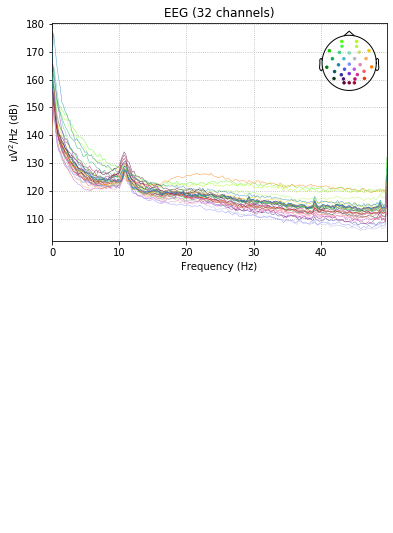

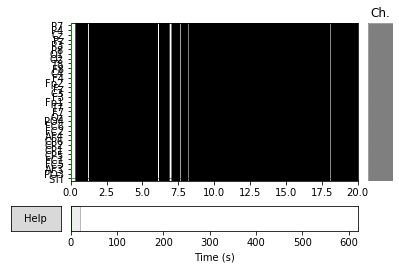

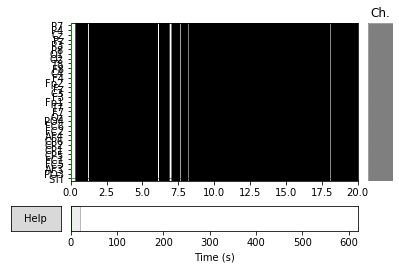

In [40]:
# raw = get_raw_and_events(path + "ExperimentalGroup\\DimiTrain1.xdf")[0]
# raw.plot_psd(fmax=50)
# raw.plot(duration=20, n_channels=33) # duration=5

raw = get_raw_and_events(path + "ControlGroup\\YaoTrain1.xdf")[0]
raw.plot_psd(fmax=50)
raw.plot(duration=20, n_channels=33) # duration=5

In [8]:
def get_epochs(raw, events, event_id=None, tmin=-1, tmax=1, reject = dict(eeg=150e-6)):
    print("-------- Creating epochs... --------------")
    # Set the settings for epoching the data
    all_events = np.unique(events[:,-1]).tolist()
    
#     Excluding channels
    if channels is not None:
        mask_array = np.zeros(len(ch_names), dtype=int)
        excl_chn = mne.pick_channels(ch_names, include=channels)
        mask_array[excl_chn] = 1
        exclude_chan = list(compress(ch_names, mask_array))
    else:
        exclude_chan=[]
        
    picks = mne.pick_types(raw.info, meg=False, eeg=True, ecg=False, eog=False, stim=False, exclude=exclude_chan)
    baseline = (None,0.5)    
    if event_id is None:
        event_id = all_events        
    # Epoch the data
    epochs =  mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, 
                         baseline=baseline, preload=True, reject=reject)
    # Check if all the epochs (nr of trials in the experiment) were extracted
    print('Number of epochs: %d' % len(epochs))
    print("-------- Epochs done! --------------")
    return(epochs)

def get_evoked(epochs):
    print("-------- Computing evoked... --------------")
    # COMPUTE EVOKED
    evoked = epochs.average()
    # remove physiological artifacts (eyeblinks, heartbeats) using SSP on baseline
    evoked.add_proj(mne.compute_proj_evoked(evoked.copy().crop(tmax=0)))
    evoked.apply_proj()
    # fix stim artifact
    mne.preprocessing.fix_stim_artifact(evoked)
    # correct delays due to hardware (stim artifact is at 4 ms)
    evoked.shift_time(-0.004)
    print("-------- Evoked done! --------------")

    return(evoked)

def plot_joined(evoked, selected_events, save=False):
    print("-------- Computing evoked... --------------")
    title=""

    for num in range(len(selected_events)):
        if num == 0:
            title=title+eventsDict[selected_events[num]]
        else:
            title=title+" & "+eventsDict[selected_events[num]]
    
    # plot the result
    fig=plot_epochs_image(epochs, evoked=True, title=title)
    if save is True:
        fig[0].savefig("./Plots/epochsImage_"+title+'.png')    
    
    time_unit = dict(time_unit="s")
    fig = evoked.plot_joint(title=title, ts_args=time_unit,
                 topomap_args=time_unit)  # show difference wave
    
    if save is True:
        fig.savefig("./Plots/evoked_joined_"+title+'.png')
    return(fig)

def process_ica(raw):    
    
    raw.filter(1, None) # not in the og

    ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800) #n_components=20 for some...
    
    #troublesome ica
    #ica = mne.preprocessing.ICA( random_state=1, method="infomax")# fit_params=dict(extended=True)
    
    ica.fit(raw, reject=None) # ica.fit(raw, reject = dict(eeg=150e-7))
    
    orig_raw = raw.copy()
    raw.load_data()
    ica.apply(raw)

    # show some frontal channels to clearly illustrate the artifact removal
    chs = ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']

    chan_idxs = [raw.ch_names.index(ch) for ch in chs]
    orig_raw.plot(order=chan_idxs, start=12, duration=4, scalings="auto")
    raw.plot(order=chan_idxs, start=12, duration=4, scalings="auto")
    
    # identifying ocular components
    
    ica.plot_components(inst=raw)
    ica.plot_sources(inst=raw)
    
    return(raw)

-------- Fetching data... --------------
checking first time stamps, EGG: 12057.230682943 

checking first time stamps, Unity: 12060.833471861726
-------- Creating raw... --------------
Creating RawArray with float64 data, n_channels=32, n_times=309627
    Range : 0 ... 309626 =      0.000 ...   619.252 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=309627
    Range : 0 ... 309626 =      0.000 ...   619.252 secs
Ready.
-------- Adding events... --------------
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)

147 events found
Event IDs: [1 2 3 4]
Number of events found: 147
-------- 

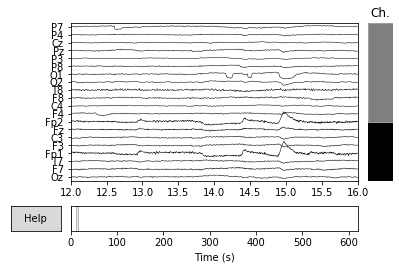

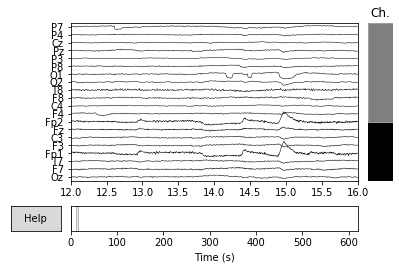

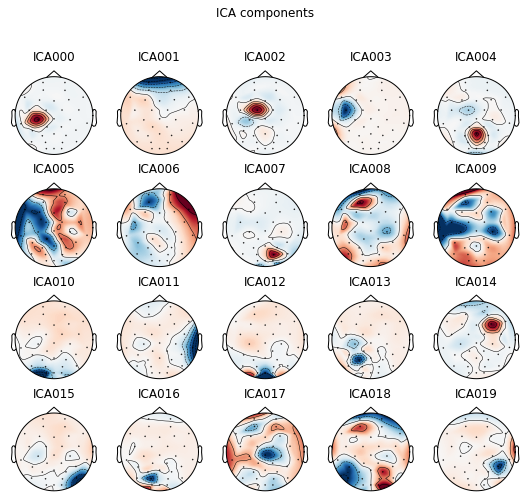

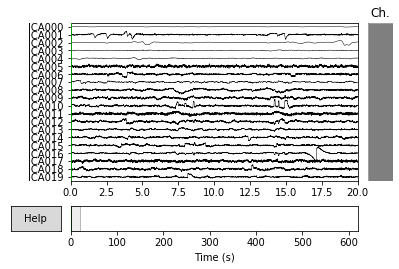

<RawArray  |  None, n_channels x n_times : 33 x 309627 (619.3 sec), ~78.0 MB, data loaded>

In [9]:

raw_yao = get_raw_and_events(path + "ControlGroup\\YaoTrain1.xdf")[0]

process_ica(raw_yao)


#raw1 = get_raw_and_events(path + "ControlGroup\\YaoTrain2.xdf")[0]

#exclude components based on ocular activity



-------- Fetching data... --------------
checking first time stamps, EGG: 4890.15187516 

checking first time stamps, Unity: 4890.201043131296
-------- Creating raw... --------------
Creating RawArray with float64 data, n_channels=32, n_times=321102
    Range : 0 ... 321101 =      0.000 ...   642.202 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=321102
    Range : 0 ... 321101 =      0.000 ...   642.202 secs
Ready.
-------- Adding events... --------------
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)

201 events found
Event IDs: [1 2 3 4 5 6]
Number of events found: 201
--------

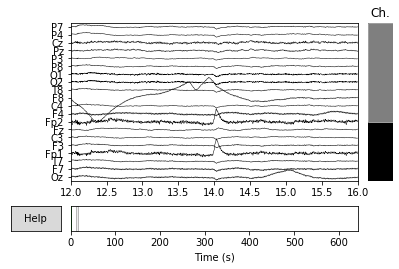

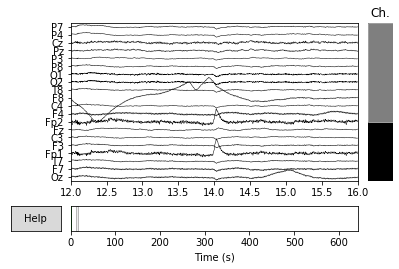

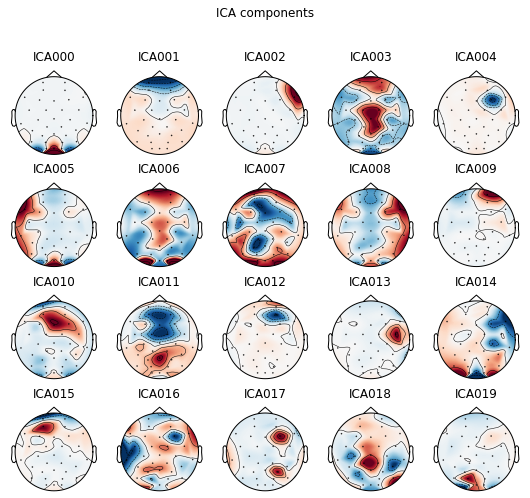

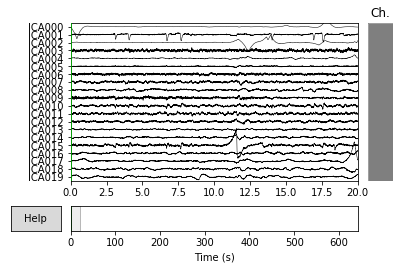

<RawArray  |  None, n_channels x n_times : 33 x 321102 (642.2 sec), ~80.9 MB, data loaded>

In [10]:
raw_annag = get_raw_and_events(path + "ExperimentalGroup\\AnnaGTrain1.xdf")[0]

process_ica(raw_annag)



In [11]:
#ica.plot_properties(raw, picks=0)
#ica_exclude_by_names = {'Yao': [0, 11], 'Emily': [0,1], 'AnnaG': [2], 'Dimi': [1,10]} 

In [12]:
event_dict_exp = {'Collision': 1, 'Missed': 2, 'Bomb': 3,
              'Spheres_generated': 4,  'auditory_stimulus': 6}

-------- Fetching data... --------------
checking first time stamps, EGG: 5686.83587516 

checking first time stamps, Unity: 5687.333719264658
-------- Creating raw... --------------
Creating RawArray with float64 data, n_channels=32, n_times=315869
    Range : 0 ... 315868 =      0.000 ...   631.736 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=315869
    Range : 0 ... 315868 =      0.000 ...   631.736 secs
Ready.
-------- Adding events... --------------
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)

203 events found
Event IDs: [1 2 3 4 6]
Number of events found: 203
-------- R

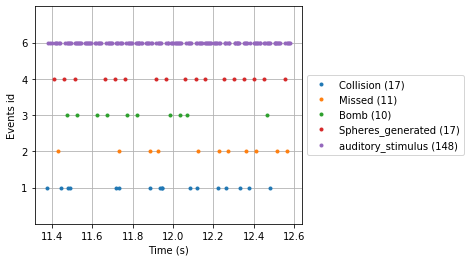

In [13]:
events = get_raw_and_events(path + "ExperimentalGroup\\AnnaGTrain2.xdf")[1]


fig = mne.viz.plot_events(events, event_id=event_dict_exp, sfreq=raw.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

-------- Fetching data... --------------
checking first time stamps, EGG: 12057.230682943 

checking first time stamps, Unity: 12060.833471861726
-------- Creating raw... --------------
Creating RawArray with float64 data, n_channels=32, n_times=309627
    Range : 0 ... 309626 =      0.000 ...   619.252 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=309627
    Range : 0 ... 309626 =      0.000 ...   619.252 secs
Ready.
-------- Adding events... --------------
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)

147 events found
Event IDs: [1 2 3 4]
Number of events found: 147
-------- 

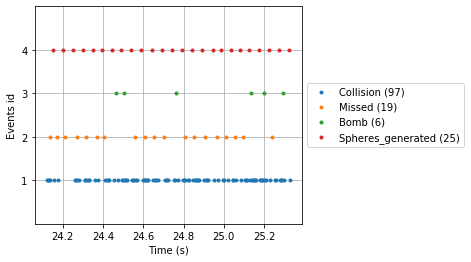

In [14]:
event_dict_control = {'Collision': 1, 'Missed': 2, 'Bomb': 3,
              'Spheres_generated': 4}

events = get_raw_and_events(path + "ControlGroup\\YaoTrain1.xdf")[1]

fig = mne.viz.plot_events(events, event_id=event_dict_control, sfreq=raw.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

In [20]:
#get_epochs(raw, events, event_id=None, tmin=-1, tmax=1, reject = dict(eeg=150e-6))
channels=["P7", "P4", "P8"]

ch_names = ('P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3')

raw_Yao_train1 = get_raw_and_events(path + "ControlGroup\\YaoTrain1.xdf")[0]

events_Yao_train1 = get_raw_and_events(path + "ControlGroup\\YaoTrain1.xdf")[1]

get_epochs(raw_Yao_train1, events_Yao_train1)


-------- Fetching data... --------------
checking first time stamps, EGG: 12057.230682943 

checking first time stamps, Unity: 12060.833471861726
-------- Creating raw... --------------
Creating RawArray with float64 data, n_channels=32, n_times=309627
    Range : 0 ... 309626 =      0.000 ...   619.252 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=309627
    Range : 0 ... 309626 =      0.000 ...   619.252 secs
Ready.
-------- Adding events... --------------
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)

147 events found
Event IDs: [1 2 3 4]
Number of events found: 147
-------- 

    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based o

    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based o

    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based o

    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based on EEG : ['P7', 'P4', 'Cz', 'Pz', 'P3', 'P8', 'O1', 'O2', 'T8', 'F8', 'C4', 'F4', 'Fp2', 'Fz', 'C3', 'F3', 'Fp1', 'T7', 'F7', 'Oz', 'PO4', 'FC6', 'FC2', 'AF4', 'CP6', 'CP2', 'CP1', 'CP5', 'FC1', 'FC5', 'AF3', 'PO3']
    Rejecting  epoch based o

<Epochs  |   0 events (all good), -1 - 1 sec, baseline [None, 0.5], ~91 kB, data loaded,
 '1': 0
 '2': 0
 '3': 0
 '4': 0>

In [ ]:
get_evoked(epochs)